In [ ]:
#! pip install tensorflow tensorflow-gpu matplotlib tensorflow-dataset ipywidgets

In [ ]:
!pip list

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [8]:
df = tfds.load('fashion_mnist', split = 'train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete6VJ43T/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete6VJ43T/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [11]:
df.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

## **Visualisation of dataset**

In [12]:
import numpy as np

In [13]:
#Setup connection aka iterator
data_iterator = df.as_numpy_iterator()

In [ ]:
#Getting data out of pipeline
data_iterator.next()

In [16]:
data_iterator.next()['image'].shape

(28, 28, 1)

In [17]:
np.squeeze(data_iterator.next()['image']).shape

(28, 28)

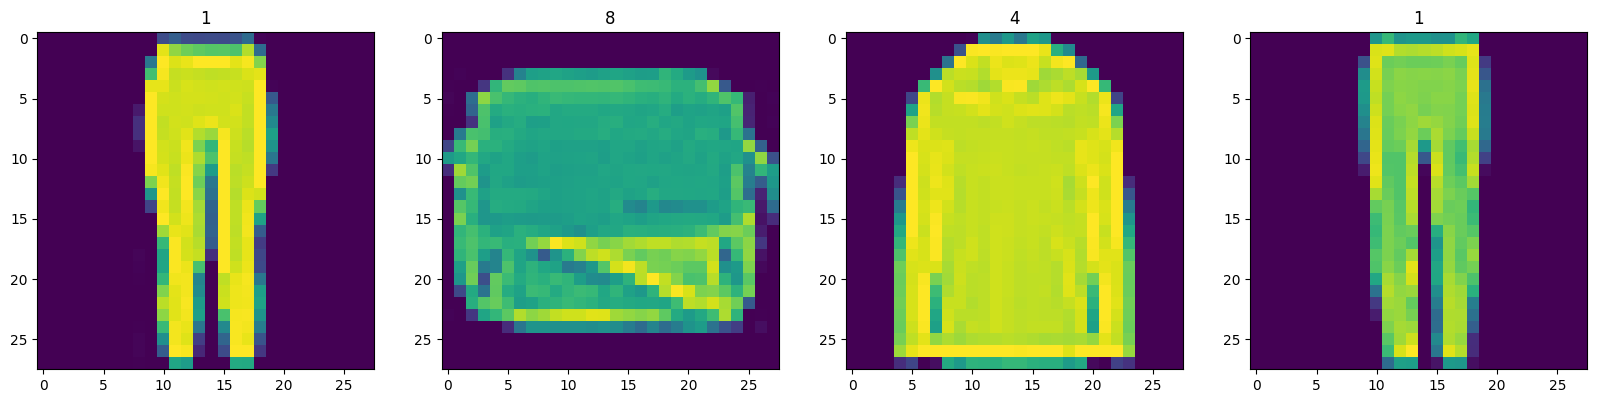

In [15]:
fig, ax = plt.subplots(ncols = 4, figsize =(20,20))
for idx in range(4):
  #Get image and label
  sample = data_iterator.next()
  #Plot image using a specific subplots
  ax[idx].imshow(np.squeeze(sample['image']))
  #Appending image label as plt title
  ax[idx].title.set_text(sample['label'])

The label or title 1 indicates the jeans/pants, 8 indicates the bag and so on.

In [18]:
#Scale and return image only
def scale_images(data):
  image = data['image']
  return image/255

In [20]:
#Reload the dataset
ds = tfds.load('fashion_mnist', split='train')
#Running the dataset through the scale_images processing step
ds = ds.map(scale_images)
#Cache the dataset for batch
ds = ds.cache()
#Shufling the data
ds = ds.shuffle(60000)
#Batch the dataset for 128 batch
ds = ds.batch(128)
#reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [21]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## **Build Neural Network**

Import modelling components

In [22]:
#Importing sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, Dropout, LeakyReLU, UpSampling2D

Build the Genrator

In [29]:
from keras.api._v2.keras import activations
def build_generator():
  model = Sequential()
  #Takes the random values and reshape it to 7x7x128
  model.add(Dense(7*7*128, input_dim = 128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  #Upsampling the block1
  model.add(UpSampling2D()) #doubles the shape of image from 7x7x128 to 14x14x128
  model.add(Conv2D(128, 5, padding= 'same'))
  model.add(LeakyReLU(0.2))

  #Upsampling the block2
  model.add(UpSampling2D())  #doubles the shape of image from 14x14x128 to 28x28x128
  model.add(Conv2D(128, 5, padding= 'same'))
  model.add(LeakyReLU(0.2))

  #Downsampling the block 1
  model.add(Conv2D(128, 4, padding= 'same'))
  model.add(LeakyReLU(0.2))

  #Downsampling the block 2
  model.add(Conv2D(128, 4, padding= 'same'))
  model.add(LeakyReLU(0.2))

  #Conv layer
  model.add(Conv2D(1, 4, padding='same', activation= 'sigmoid'))



  return model

In this code we are reshaping and upsampling the images from (7x7x128) to (14x14x128) to (28x28x128) which is the actual shape of image

In [32]:
generator = build_generator()

In [33]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_3 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                      

1/1 [==============================] - 0s 27ms/step


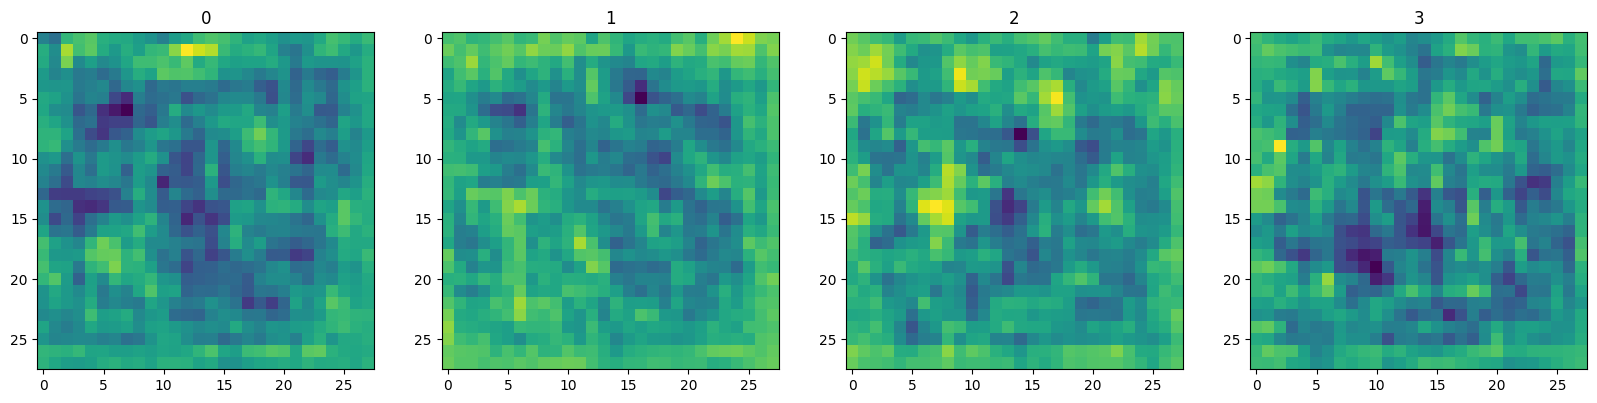

In [47]:
#Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
#setup subplot formatting
fig, ax = plt.subplots(ncols = 4, figsize =(20,20))
for idx, img in enumerate(img):
  #Plot image using a specific subplots
  ax[idx].imshow(np.squeeze(img))
  #Appending image label as plt title
  ax[idx].title.set_text(idx)

Build Discriminator

In [49]:
def build_discriminator():
  model = Sequential()
  #First Conv block
  model.add(Conv2D(32,5, input_shape = (28,28,1)))
  model.add(LeakyReLU(0.2)) #activation layer
  model.add(Dropout(0.4))

  #Second Conv block
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2)) #activation layer
  model.add(Dropout(0.4))

  #Third Conv block
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2)) #activation layer
  model.add(Dropout(0.4))

  #Fourth Conv block
  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2)) #activation layer
  model.add(Dropout(0.4))

  #Flatten
  model.add(Flatten())
  model.add(Dropout(0.4))

  #Passing to dense layer
  model.add(Dense(1, activation = 'sigmoid'))

  return model

In [50]:
discriminator = build_discriminator()

In [51]:
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_9 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 128)      

In [52]:
img.shape

(28, 28, 1)

In [54]:
discriminator.predict(np.expand_dims(img,0))

1/1 [==============================] - 0s 79ms/step


array([[0.5051907]], dtype=float32)

# **Construct Training loop**

Setup losses and Optimizers

In [55]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [56]:
g_opt = Adam(learning_rate=0.0001) #optimizer for generator
d_opt = Adam(learning_rate=0.00001) #optimizer for discriminator
g_loss = BinaryCrossentropy() #loss for generator
d_loss = BinaryCrossentropy() #loss for discriminator

Build Subclass Model

In [57]:
#Importing the base model to subclass training step
from tensorflow.keras.models import Model

In [67]:
from keras.engine.sequential import training
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)
    #Create attributes for  gen and disc
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, g_loss, d_opt, d_loss, *args, **kwargs):
    super().compile(*args, **kwargs)
    #Create attributes for losses and optimizers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def train_step(self, batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)), training= False)

    #Train the discriminator
    with tf.GradientTape() as d_tape:
      #Pass the real and fake images to the discriminator
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      #create labels for real and fake images
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
      #Add some noise to output
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      #calculate loss
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    #Apply backpropogation and learn
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    #Train the generator
    with tf.GradientTape() as g_tape:
      #generate the images
      gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
      #create the predicted labels
      predicted_labels = self.discriminator(gen_images, training=False)
      #calculate the loss
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    #Apply backpropogation
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"d_loss": total_d_loss, "g_loss": total_g_loss}

In [68]:
#Creating the instance of subclass model
fashgan = FashionGAN(generator, discriminator)

In [69]:
#Compile the Model
fashgan.compile(g_opt, g_loss, d_opt, d_loss)

Build CallBack

In [70]:
import os
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import array_to_img

In [71]:
class ModelMonitor(Callback):
  def __init__(self, num_img=3, latent_dim = 128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [73]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=20)

Epoch 1/20
469/469 [==============================] - 76s 161ms/step - d_loss: 0.3540 - g_loss: 3.7160
Epoch 2/20
469/469 [==============================] - 75s 161ms/step - d_loss: 0.2845 - g_loss: 3.6810
Epoch 3/20
469/469 [==============================] - 75s 161ms/step - d_loss: 0.2747 - g_loss: 2.6608
Epoch 4/20
469/469 [==============================] - 75s 161ms/step - d_loss: 0.2732 - g_loss: 2.6799
Epoch 5/20
469/469 [==============================] - 75s 161ms/step - d_loss: 0.2714 - g_loss: 2.6727
Epoch 6/20
469/469 [==============================] - 75s 161ms/step - d_loss: 0.2707 - g_loss: 2.6565
Epoch 7/20
469/469 [==============================] - 75s 161ms/step - d_loss: 0.2706 - g_loss: 2.6497
Epoch 8/20
469/469 [==============================] - 75s 161ms/step - d_loss: 0.2695 - g_loss: 2.6478
Epoch 9/20
469/469 [==============================] - 75s 161ms/step - d_loss: 0.2688 - g_loss: 2.6534
Epoch 10/20
469/469 [==============================] - 75s 161ms/step - d

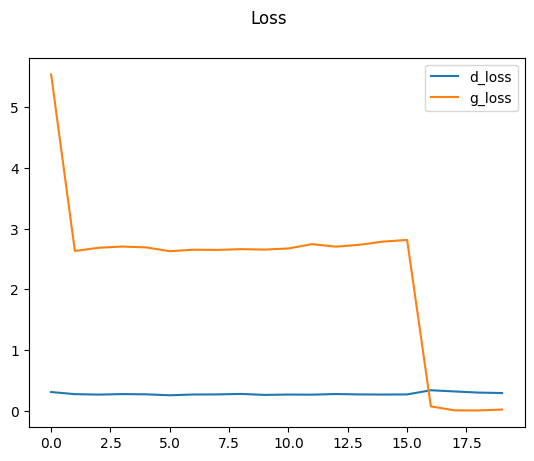

In [74]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [75]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 317ms/step


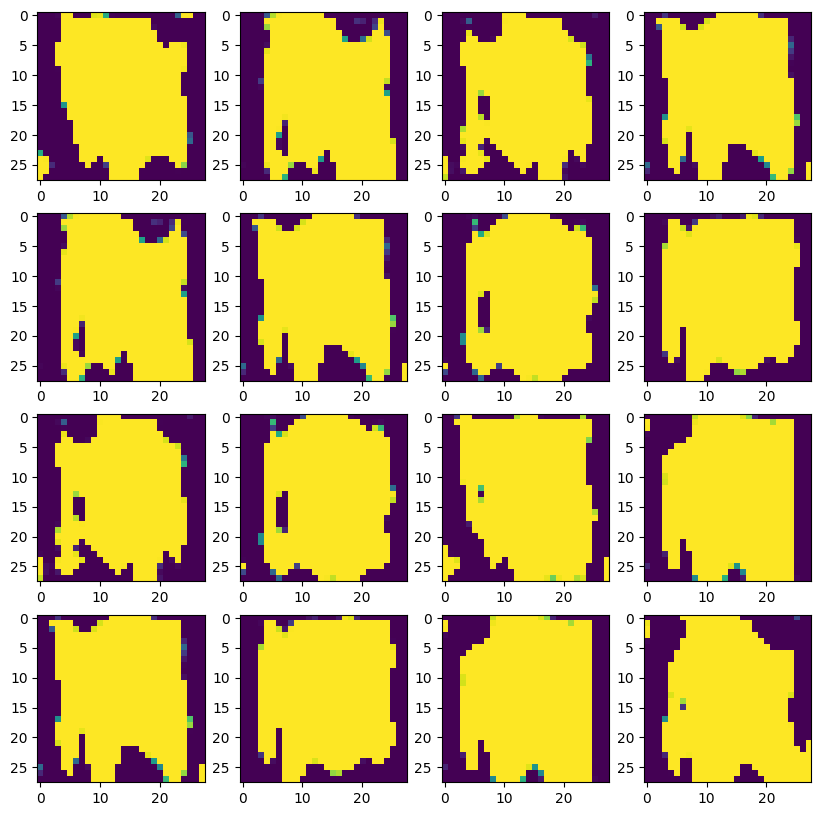

In [76]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [ ]:
~